<a href="https://colab.research.google.com/github/RayRayKing/aePlanday/blob/main/ae_planday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following analysis addressed some of the following questions:

* Overall success rate
* Individual goal completion rates
* Time it takes for successful activations
* Which goals are most correlated with overall activation
* Where in the process organizations tend to drop off (funnel analysis)


Other possible questions to address with the available data (not address in this analysis)

* How many organizations complete all but 1/2 goal? (Where to provide better visibility to focus)

* What are the most frequently viewed advanced features, least viewed, time to view for each category? (this would use the int_model instead of the mart layers)

* Most frequent order of activation that leads to trials activation (if it matters, understanding what is the highest conversation process flow)


In [44]:
from google.colab import auth
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd

auth.authenticate_user()
print('Authenticated')
from google.cloud import bigquery

client = bigquery.Client(project='softonicdatalake')

query = '''
SELECT * FROM `softonicdatalake.dbt_rhoang.mart_trial_activation`
'''
df = client.query(query=query).to_dataframe()

df.head()

Authenticated


,organization_id,trial_activation_status,trial_activation_date,shift_created_goal_status,shift_date_completed,employee_invited_goal_status,employee_date_completed,punched_in_goal_status,punched_in_date_completed,punch_approval_goal_status,punch_approval_date_completed,advanced_features_goal_status,advanced_features_date_completed
0,04962c17df34bacc9964a794846b02e0,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT
1,3bc717207f8795fced58e150317279bd,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT
2,178b6ee7f39bfb7e3a6150f2e0bc2683,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT
3,156e8fd102c92e5a04aa948c4917b747,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT,False,NaT
4,0588b52f2df79a1d8a5de80a572a06a1,False,NaT,True,2024-01-18,False,NaT,False,NaT,False,NaT,False,NaT


In [46]:
# Overall success rate (activation rate)
activation_rate = df["trial_activation_status"].mean()
print(f"Overall activation rate: {activation_rate:.2%}")

Overall activation rate: 6.50%


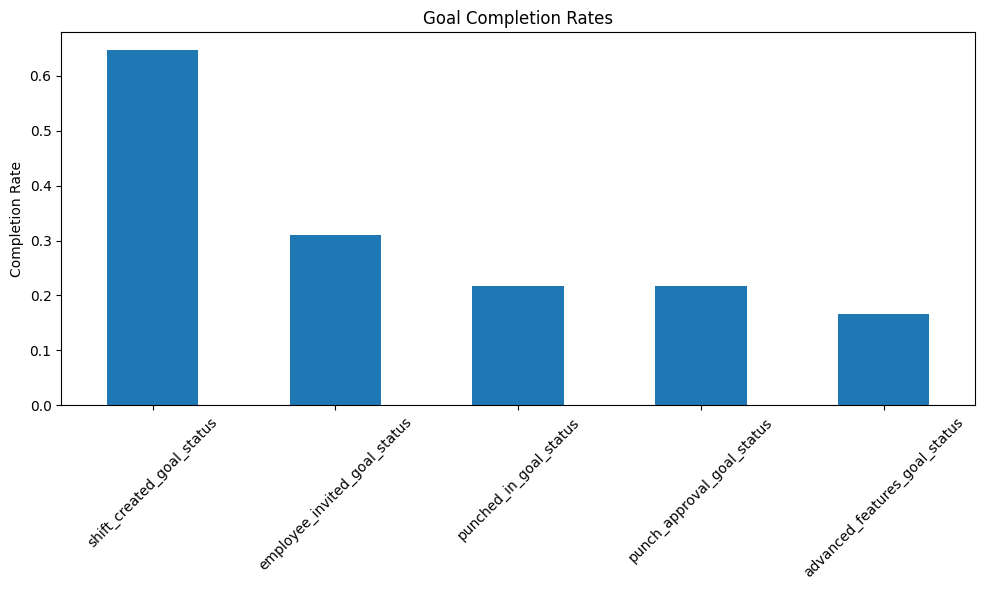

In [47]:
# Individual goal completion rates
goal_completion = df[
    ["shift_created_goal_status", "employee_invited_goal_status", "punched_in_goal_status", "punch_approval_goal_status", "advanced_features_goal_status"]].mean()
plt.figure(figsize=(10, 6))
goal_completion.plot(kind="bar")
plt.title("Goal Completion Rates")
plt.ylabel("Completion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

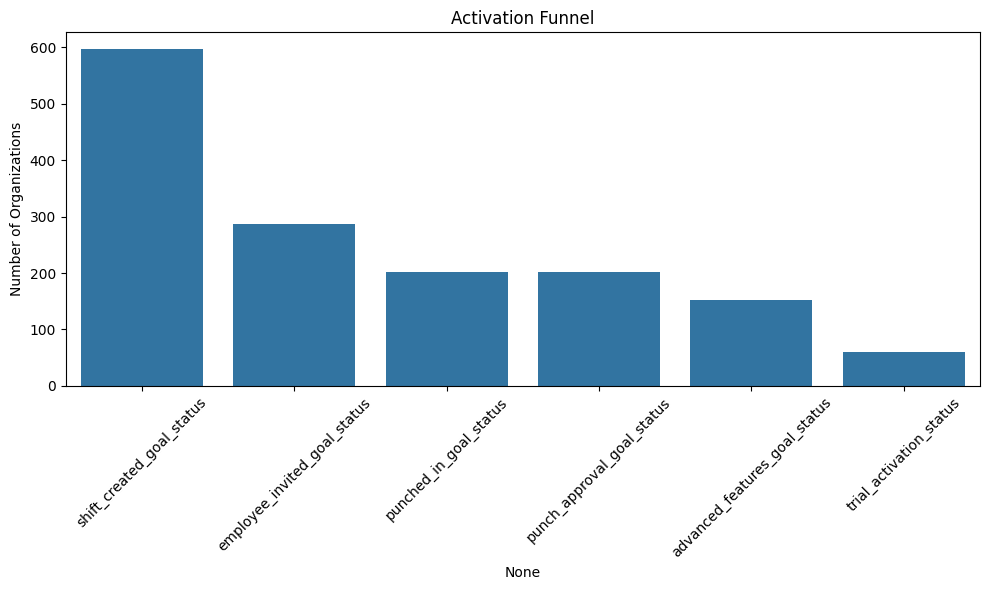

In [48]:
# More from the view of frequency instead of %.
# Picture shows that lots of shift goal achieved, but they fail to move down to the other steps.

funnel_stages = ["trial_activation_status",
     "shift_created_goal_status",
     "employee_invited_goal_status",
     "punched_in_goal_status",
     "punch_approval_goal_status",
     "advanced_features_goal_status"]
funnel_data = df[funnel_stages].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=funnel_data.index, y=funnel_data.values)
plt.title("Activation Funnel")
plt.ylabel("Number of Organizations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

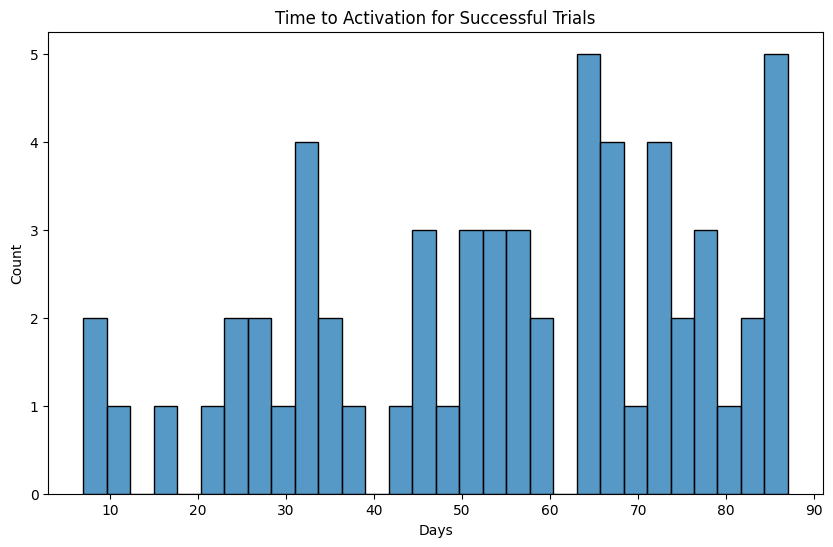

In [51]:
# Time to trial activation analysis

# Assumed start date for all entire trial period
start_date = pd.Timestamp("2024-01-01")

# Can replace trial_activation_date with any other goal dates to calculate time to completion
dimension_to_check = "trial_activation_date"

# Type check
df[dimension_to_check] = pd.to_datetime(df[dimension_to_check])


df["time_to_activation"] = (df[dimension_to_check] - start_date).dt.days
activated_trials = df[df["time_to_activation"].notnull()]

plt.figure(figsize=(10, 6))
sns.histplot(data=activated_trials, x="time_to_activation", bins=30)
plt.title("Time to Activation for Successful Trials")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()

In [50]:
correlation = df[
    ["trial_activation_status",
     "shift_created_goal_status",
     "employee_invited_goal_status",
     "punched_in_goal_status",
     "punch_approval_goal_status",
     "advanced_features_goal_status"]].corr()["trial_activation_status"].sort_values(ascending=False)

print("Correlation between goal completion and overall activation:")
print(correlation)


Correlation between goal completion and overall activation:
trial_activation_status          1.000000
advanced_features_goal_status    0.591521
punched_in_goal_status           0.499736
punch_approval_goal_status       0.499736
employee_invited_goal_status     0.392516
shift_created_goal_status        0.194846
Name: trial_activation_status, dtype: float64
